In [1]:
from __future__ import print_function
from __future__ import division

import make_dictionaries
import os
import math
import params

import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time
from voronoi_2d_binning import voronoi_2d_binning
from sklearn.neighbors import NearestNeighbors

In [2]:
import binning
import bin_debiasing

In [3]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [47]:
source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5#np.log10(0.1)
max_log_fv = 0.01

Question to be debiased: t01_smooth_or_features


In [5]:
data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded galaxy data...
Loaded questions...
Loaded functions...


In [17]:
#for question in questions.keys():
    #for answer in questions[question]['answers']:
        #print(question + '_' + answer + '_weighted_fraction')
        
question = 't01_smooth_or_features'
answer = 'a02_features_or_disk'

In [18]:
low_z_lim = 0.03
data = data[data['REDSHIFT_1'] > low_z_lim]

Bin-accretion...
2070  initial bins.
Reassign bad bins...
25  good bins.
Modified Lloyd algorithm...
23  iterations.
Unbinned pixels:  0  /  39099
Fractional S/N scatter (%): 9.6644937707
25 voronoi bins
82.96 redshift bins per voronoi bin


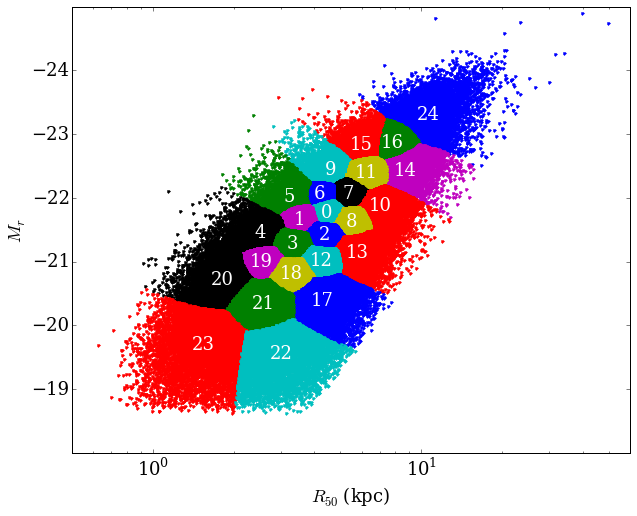

In [19]:
vbins,zbins,zbins_coarse,vbins_table = binning.bin_data(data,question,answer,plot=True,signal=100)

In [20]:
debiased_bin = bin_debiasing.debias(data,vbins,zbins,question,answer)

In [21]:
def make_fit_setup(function_dictionary,key):
    fit_setup = {}
    fit_setup['func'] = function_dictionary['func'][key]
    fit_setup['bounds'] = function_dictionary['bounds'][key]
    fit_setup['p0'] = function_dictionary['p0'][key]
    fit_setup['inverse'] = function_dictionary['i_func'][key]
    return fit_setup


def get_best_function(data,vbins,zbins,functions,question,answer):
    
    chisq_tot = np.zeros(len(function_dictionary['func'].keys()))
    k_tot = np.zeros(len(function_dictionary['func'].keys()))
    c_tot = np.zeros(len(function_dictionary['func'].keys()))
    
    for n,key in enumerate(function_dictionary['func'].keys()):

        fit_setup = make_fit_setup(functions,key)
        fit_vbin_results = fit_vbin_function(data,vbins,zbins,fit_setup,question,answer)
        
        chisq = np.sum(fit_vbin_results['chi2nu'])
        k = np.mean(fit_vbin_results['k'])
        c = np.mean(fit_vbin_results['c'])
        
        chisq_tot[n] = chisq
        k_tot[n] = k
        c_tot[n] = c
        print('chisq({}) = {}'.format(function_dictionary['label'][key],chisq))
    
    n = np.argmin(chisq_tot)
    keys = [key for key in function_dictionary['func'].keys()]
    key = keys[n]
    fit_setup = make_fit_setup(functions,key)
    fit_setup['p0'] = [k_tot[n],c_tot[n]] # mean values to start the fitting from.
    
    return fit_setup 


def get_fit_setup(fit_setup):

    func = fit_setup['func']
    p0 = fit_setup['p0']
    bounds = fit_setup['bounds']
    
    return func, p0, bounds

In [62]:
def chisq_fun(p, f, x, y):
    return ((f(x, *p) - y)**2).sum()


def fit_vbin_function(data, vbins, zbins, fit_setup,
                      question,answer,kc_fit_results=None,
                      min_log_fv=min_log_fv,
                      even_sampling=True):
    
    start_time = time.time()

    redshift = data['REDSHIFT_1']
    fv = question + '_' + answer +'_weighted_fraction'
    
    if kc_fit_results is not None:
        kcfunc, kparams, cparams, lparams,kclabel = kc_fit_results
    
    # Set up the list to write the parameters in to:
    param_data = []
    
    max_z_bins_to_plot = 5
    
    bounds = fit_setup['bounds']
    p0 = fit_setup['p0']
    func = fit_setup['func']
    
    colours = ['b','g','k','r']
    xg = np.linspace(-2,0,100)
    
    # Loop over Voronoi magnitude-size bins
    for v in np.unique(vbins):
        vselect = vbins == v
        data_v = data[vselect]
        zbins_v = zbins[vselect]

        z_bins_unique = np.unique(zbins_v)

        for z in z_bins_unique:
            data_z = data_v[zbins_v == z]
            n = len(data_z)
            
            D = data_z[[fv]]
            D.sort(fv)
            D['cumfrac'] = np.linspace(0, 1, n)
                #D = D[D[fv] > min_fv]
            D['log10fv'] = np.log10(D[fv])
            if even_sampling:
                D_fit_log10fv = np.log10(np.linspace(10**(min_log_fv), 1, 1000))
                D = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)]
                indices = np.searchsorted(D['log10fv'], D_fit_log10fv)
                D_fit = D[indices.clip(0, len(D)-1)]
            else:
                D_fit = D[D['log10fv'] > min_log_fv]

            res = minimize(chisq_fun, p0,
                           args=(func,
                                 D_fit['log10fv'].astype(np.float64),
                                 D_fit['cumfrac'].astype(np.float64)),
                           bounds=bounds, method='SLSQP')
            p = res.x
            chi2nu = res.fun / (n - len(p))
                
            means = [data_z['PETROMAG_MR'].mean(),
                     np.log10(data_z['PETROR50_R_KPC']).mean(),
                     data_z['REDSHIFT_1'].mean()]

            if len(p) < 2:
                p = np.array([p[0], 10])

            param_data.append([v,z] + means + p[:2].tolist() + # Maybe change output table here
                              [chi2nu])
            
    fit_vbin_results = Table(rows=param_data,
                             names=('vbin','zbin', 'Mr',
                                    'R50', 'redshift', 'k', 'c', 'chi2nu'))
    
    print('All bins fitted! {}s in total'.format(time.time()-start_time))
    
    return fit_vbin_results

In [23]:
fit_setup = get_best_function(data,vbins,zbins_coarse,
                              function_dictionary,question,answer)

All bins fitted! 17.80854368209839s in total
chisq(logistic) = 0.04623480159018116
All bins fitted! 17.040456295013428s in total
chisq(exp. power) = 0.03158707593868881


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log10


In [24]:
def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction'):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=True,sharey=True,figsize=(5*x_dimension,5*y_dimension))
    if n_morph >= 3:
        for ax in axes[-1,:]:
            ax.set_xlabel(xlabel)
        for ax in axes[:,0]:
            ax.set_ylabel(ylabel) 
    else:
        axes[0].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)
        axes[1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes

In [25]:
def plot_fit_vbin(question,questions,parameter='k', predictor=None):
    
    answerlabels = questions[question]['answerlabels']
    
    n_morph = 1
    fig, axarr = plt.subplots(n_morph, 3, sharey='row', sharex='col', figsize=(15,3*n_morph))
    def plot(ax, x, answer, colourby):
        r = fit_vbin_results[fit_vbin_results['answer'] == answer]
        if predictor is None:
            param = r[parameter]
        else:
            f, p = predictor
            var = np.array([r[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
            if p is not None:
                param = f(var, *p[answer])
            else:
                param = f(var)
        ax.scatter(r[x], param, c=r[colourby], marker='.', edgecolor='')
        y, bin_edges, binnumber = binned_statistic(r[x], r[parameter], statistic='median')
        xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.plot(xc, y, 'k-')
        if predictor is not None:
            y, bin_edges, binnumber = binned_statistic(r[x], param, statistic='median')
            xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            ax.plot(xc, y, 'k--')
        low, high = plot_limits(r[parameter])
        ax.axis(ymin=low, ymax=high)
    for a, axrow in enumerate(axarr):
        plot(axrow[0], 'redshift', a, 'vbin')
        plot(axrow[1], 'R50', a, 'redshift')
        plot(axrow[2], 'Mr', a, 'redshift')
        axrow[0].set_ylabel("${}$ ({})".format(parameter,answerlabels[a]))
        if a == len(axarr) - 1:
            axrow[0].set_xlabel('$z$')
            axrow[1].set_xlabel('$\log_{10}{R_{50}}$')
            axrow[2].set_xlabel('$M_r$')
    fig.subplots_adjust(hspace=0, wspace=0)

In [26]:
from scipy.optimize import curve_fit


def kcfunc(x, A0, AM, AR, Az):#,nz):
    # linear combination of (magnitude, size, redshift) + an offset
    #logr = A0 + AM*(10**(x[0])) + AR*(x[1]) + Az*(x[2])
    
    logr = A0 + AM*(10**(x[0])) + AR*(x[1]) + Az*(x[2])
    
    return logr


def fit_mrz(d, f_k, f_c, clip=None,plot=True):
    # Fit a linear function of M, R and z to k and c
    
    dout = d.copy()
    dout['kf'] = np.zeros(len(d))
    dout['cf'] = np.zeros(len(d))
    
    kparams = []
    cparams = []
    # Set limits of the functions here.
    kmin = d['k'].min() 
    kmax = d['k'].max() 
    cmin = d['c'].min()
    cmax = d['c'].max()

    # Loop over GZ morphologies
    x = np.array([d[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
    k = d['k'].astype(np.float64)
    c = d['c'].astype(np.float64)

    kp, kc = curve_fit(f_c, x, k, maxfev=100000)
    cp, cc = curve_fit(f_k, x, c, maxfev=100000)
        
    kres = f_k(x, *kp) - k
    knormres = normalise(kres)

    cres = f_c(x, *cp) - c
    cnormres = normalise(cres)
    
    bins = np.linspace(-3,3,15)
    
    if plot == True:
    
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.hist(knormres,color='r',alpha=0.5,bins=bins)
        plt.xlabel('residual k')
        plt.ylabel('N')
    
        plt.subplot(1,2,2)
        plt.hist(cnormres,color='b',alpha=0.5,bins=bins)
        plt.xlabel('residual c')
        plt.ylabel('N')
        
    if clip != None:
        
        clipped = ((np.absolute(knormres) < clip) & (np.absolute(cnormres) < clip))# 'clip' sigma clipping
        kp, kc = curve_fit(f_k, ((x.T)[clipped]).T, k[clipped], maxfev=100000)
        cp, cc = curve_fit(f_c, ((x.T)[clipped]).T, c[clipped], maxfev=100000)
        
        if plot == True:
            plt.subplot(1,2,1)
            plt.hist(knormres[clipped],color='r',bins=bins)
            plt.xlabel('residual k')
            plt.ylabel('N')
        
            plt.subplot(1,2,2)
            plt.hist(cnormres[clipped],color='b',bins=bins)
            plt.xlabel('residual c')
            plt.ylabel('N')
        
    dout['kf'] = f_k(x, *kp)
    dout['cf'] = f_c(x, *cp)
        
    kparams.append(kp)
    cparams.append(cp)

    return kparams, cparams,  dout, kmin, kmax, cmin, cmax


def normalise(x):
    return (x - x.mean())/x.std()

In [27]:
#fit_vbin_results = fit_vbin_function(data, vbins, zbins_coarse, fit_setup,
                                     #question,answer)

def normalise_tot(x,mean,std):
    return (x - mean)/std


def get_term(constant,var,t='linear'):
    
    if t == 'log':
        term = constant*np.log10(var)
    elif t == 'linear':
        term = constant*var
    else:
        term = constant*(10**(var))
    return term
    

def get_func(M_dependence,R_dependence,z_dependence):
    
    def kcfunc(x,A0,AM,AR,Az):
        M_term = get_term(AM,x[0],M_dependence)
        R_term = get_term(AR,x[1],R_dependence)
        z_term = get_term(Az,x[2],z_dependence)
        return A0 + M_term + R_term + z_term

    return kcfunc

In [64]:
fit_vbin_results = fit_vbin_function(data, vbins, zbins, fit_setup,
                      question,answer)

All bins fitted! 308.6515483856201s in total


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10


In [29]:
c_residuals = np.zeros(3**3)
k_residuals = np.zeros(3**3)
i = 0
M_dependences = []
R_dependences = []
z_dependences = []

finite_select = (np.isfinite(fit_vbin_results['k'])) & (np.isfinite(fit_vbin_results['c']))
fit_vbin_results_finite = fit_vbin_results[finite_select]

for M_dependence in ['log','linear','exp']:
    for R_dependence in ['log','linear','exp']:
        for z_dependence in ['log','linear','exp']:
            kcfunc = get_func(M_dependence,R_dependence,z_dependence)
            kparams, cparams,dout, kmin, kmax, cmin, cmax = fit_mrz(fit_vbin_results_finite, kcfunc,
                                                                    kcfunc,clip=None,plot=False)
            
            k_mean = np.mean(dout['k'])
            k_std = np.std(dout['k'])
            c_mean = np.mean(dout['c'])
            c_std = np.mean(dout['c'])
            
            k_fit_residuals = dout['kf']-dout['k']
            k_total_residual = normalise_tot(np.sum(k_fit_residuals[np.isfinite(k_fit_residuals)]),k_mean,k_std)
            c_fit_residuals = dout['cf']-dout['c']
            c_total_residual = normalise_tot(np.sum(c_fit_residuals[np.isfinite(c_fit_residuals)]),c_mean,c_std)

            k_residuals[i] = k_total_residual
            c_residuals[i] = c_total_residual
            i = i+1
            
            M_dependences.append(M_dependence)
            R_dependences.append(R_dependence)
            z_dependences.append(z_dependence)
            
k_residuals[np.isfinite(k_residuals) == False] = 10**8
c_residuals[np.isfinite(c_residuals) == False] = 10**8

best_k = np.argmin(k_residuals)
best_c = np.argmin(c_residuals)

best_M_k = M_dependences[best_k]
best_R_k = R_dependences[best_k]
best_z_k = z_dependences[best_k]
best_M_c = M_dependences[best_c]
best_R_c = R_dependences[best_c]
best_z_c = z_dependences[best_c]

k_func = get_func(best_M_k,best_R_k,best_z_k)
c_func = get_func(best_M_c,best_R_c,best_z_c)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10


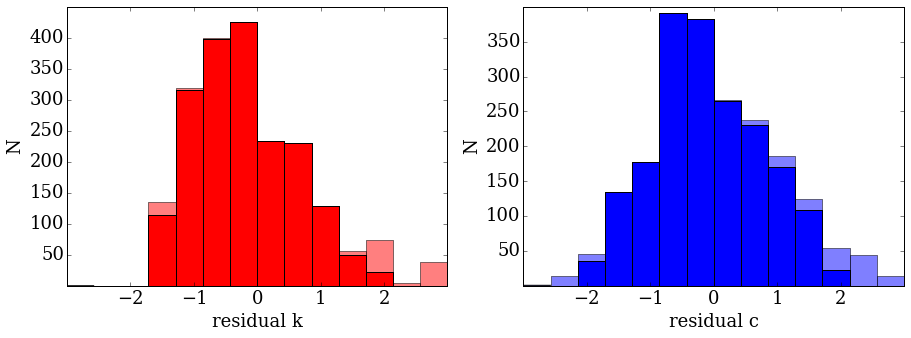

In [30]:
kparams, cparams,dout, kmin, kmax, cmin, cmax = fit_mrz(fit_vbin_results, k_func,
                                                        c_func,clip=2,plot=True)

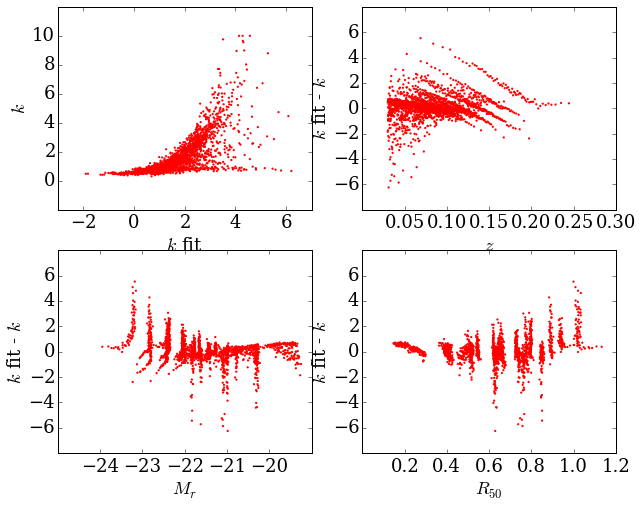

In [31]:
colours = 'r'

plt.subplot(2,2,1)

plt.scatter(dout['kf'], dout['k'], c=colours,
            marker='.', edgecolor='', alpha=1)

plt.xlabel('$k$ fit')
plt.ylabel('$k$')

#plt.axis([0,50,0,50])

plt.subplot(2,2,2)

plt.scatter(dout['redshift'], dout['kf']-dout['k'], c=colours,
            marker='.', edgecolor='', alpha=1)

plt.xlabel('$z$')
plt.ylabel('$k$ fit - $k$')

plt.subplot(2,2,3)

plt.scatter(dout['Mr'], dout['kf']-dout['k'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$M_r$')
plt.ylabel('$k$ fit - $k$')

plt.subplot(2,2,4)

plt.scatter(dout['R50'], dout['kf']-dout['k'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$R_{50}$')
plt.ylabel('$k$ fit - $k$')

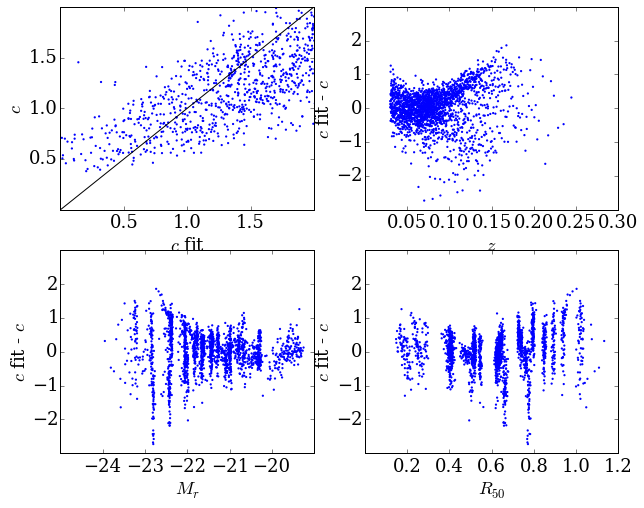

In [32]:
colours = 'b'

plt.subplot(2,2,1)

plt.scatter(dout['cf'], dout['c'], c=colours,
            marker='.', edgecolor='', alpha=1)

plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$c$ fit')
plt.ylabel('$c$')
_ = plt.axis((0, 2, 0, 2))

plt.subplot(2,2,2)

plt.scatter(dout['redshift'], dout['cf']-dout['c'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$z$')
plt.ylabel('$c$ fit - $c$')

plt.subplot(2,2,3)

plt.scatter(dout['Mr'], dout['cf']-dout['c'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$M_r$')
plt.ylabel('$c$ fit - $c$')

plt.subplot(2,2,4)

plt.scatter(dout['R50'], dout['cf']-dout['c'], c=colours,
            marker='.', edgecolor='', alpha=1)
plt.xlabel('$R_{50}$')
plt.ylabel('$c$ fit - $c$')

In [33]:
def function_inversion(value,func,k,kb,c,cb):
    # for use when function has no mathematical inverse
    xg = np.log10(np.linspace(0.01,1,100))
    low_z_values = func(xg,kb,cb,lb)
    high_z_value = func(value,k,c,l)
    i = (np.abs(low_z_values-high_z_value)).argmin()
    x = xg[i]
    return x

In [34]:
def debias(data, z_base, k_func,c_func, kparams, cparams,
           question,answer,kmin,kmax,cmin,cmax):
    # Debias the dataset
    
    fv_col = question + '_' + answer + '_weighted_fraction'
    # Each galaxy gets a function fit to its M,R and z parameters, which are scaled
    # to the equivalent M and r functions at low z.
    
    fv = data[fv_col]
    debiased = np.zeros(len(fv))
    fv_nonzero = fv > 0
    log10fv = np.log10(np.asarray(fv[fv_nonzero]))
    func, _, _ = get_fit_setup(fit_setup)
    i_func = fit_setup['inverse']
    bounds = fit_setup['bounds']
    #------
    d  = data[fv_nonzero]
        
    x = np.array([d['PETROMAG_MR'],
                 np.log10(d['PETROR50_R_KPC']),
                 d['REDSHIFT_1']], np.float64)
    xb  = x.copy()
    xb[-1] = z_base
        
    k = k_func(x, *kparams[0])
    c = c_func(x, *cparams[0])
    
    k[k < kmin] = kmin
    k[k > kmax] = kmax
    c[c < cmin] = cmin
    c[c > cmax] = cmax

    #create version of x with all redshifts at z_base
    kb = k_func(xb, *kparams[0])
    cb = c_func(xb, *cparams[0])
        
    kb[kb < kmin] = kmin
    kb[kb > kmax] = kmax
    cb[cb < cmin] = cmin
    cb[cb > cmax] = cmax
        
    cumfrac = func(log10fv, k, c)
    log10fv_debiased = i_func(cumfrac, kb, cb)
        
    fv_debiased = 10**(log10fv_debiased)
    debiased[fv_nonzero] = fv_debiased

    return debiased

In [35]:
debiased_fit = debias(data,0.03, k_func,c_func, kparams, cparams,
                      question,answer,kmin,kmax,cmin,cmax)

In [36]:
raw_data = data[question + '_' + answer + '_weighted_fraction']
w13_data = data[question + '_' + answer + '_debiased']
volume_ok = (data['REDSHIFT_1'] <= 0.085) & (data['PETROMAG_MR'] < -21)
redshifts = data['REDSHIFT_1']

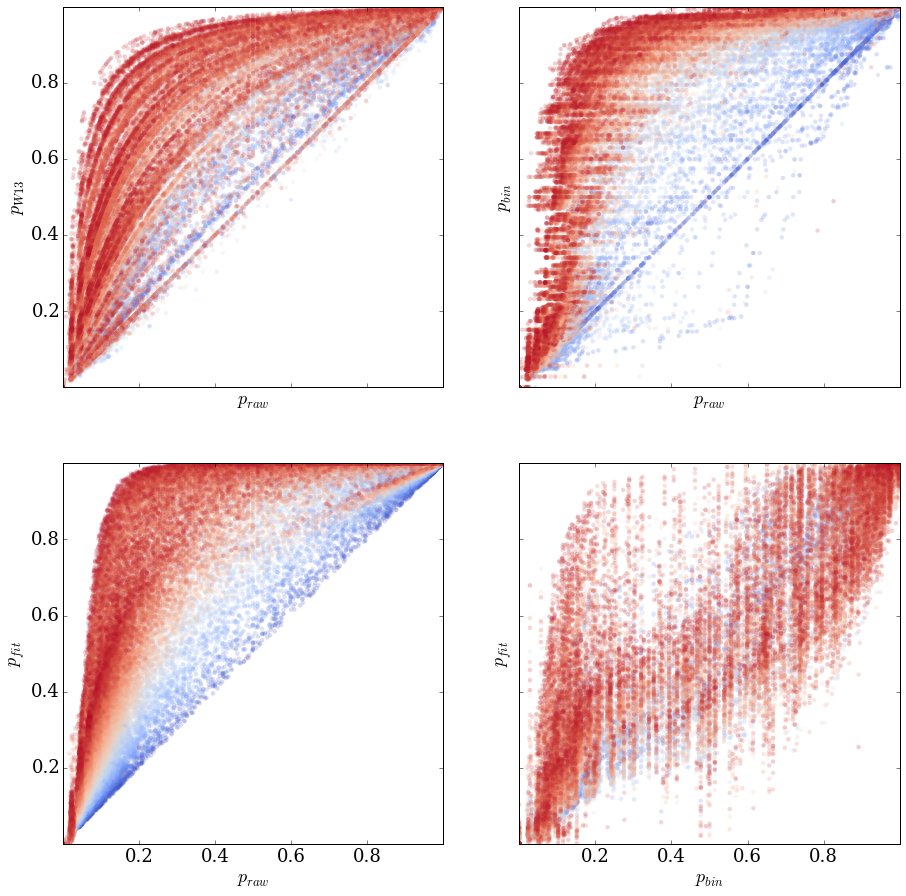

In [37]:
fig,axes = plt.subplots(2,2,figsize=(15,15),sharex=True,sharey=True)
axes = axes.ravel()
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)

axes[0].scatter(raw_data[volume_ok],w13_data[volume_ok]
                ,c=redshifts[volume_ok],cmap=plt.cm.coolwarm,lw=0,alpha=0.2)

axes[1].scatter(raw_data[volume_ok],debiased_bin[volume_ok]
                ,c=redshifts[volume_ok],cmap=plt.cm.coolwarm,lw=0,alpha=0.2)

axes[2].scatter(raw_data[volume_ok],debiased_fit[volume_ok]
                ,c=redshifts[volume_ok],cmap=plt.cm.coolwarm,lw=0,alpha=0.2)

axes[3].scatter(debiased_bin[volume_ok],debiased_fit[volume_ok]
                ,c=redshifts[volume_ok],cmap=plt.cm.coolwarm,lw=0,alpha=0.2)

xlabels = ['raw','raw','raw','bin']
ylabels = ['W13','bin','fit','fit']

for m,ax in enumerate(axes):
    
    ax.set_xlabel('$p_{{{}}}$'.format(xlabels[m]))
    ax.set_ylabel('$p_{{{}}}$'.format(ylabels[m]))

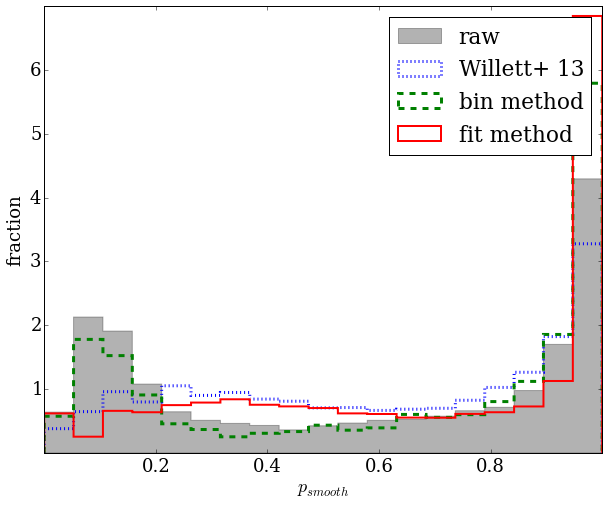

In [38]:
# Now plot some comparison histograms

low_z = (data['REDSHIFT_1'] > 0.03) & (data['REDSHIFT_1'] < 0.04)
high_z = (data['REDSHIFT_1'] > 0.07) & (data['REDSHIFT_1'] < 0.08)
bins = np.linspace(0,1,20)
lb = ['raw','Willett+ 13','bin method','fit method']

_ = plt.hist(raw_data[volume_ok*low_z]
             ,histtype='stepfilled',color='k',alpha=0.3
             ,normed=True,bins=bins,label=lb[0])

_ = plt.hist(w13_data[volume_ok*high_z]
             ,histtype='step',color='b',linewidth=3,linestyle='dotted'
             ,normed=True,bins=bins,label=lb[1])

_ = plt.hist(debiased_bin[volume_ok*high_z]
             ,histtype='step',color='g',linewidth=3,linestyle='dashed'
             ,normed=True,bins=bins,label=lb[2])

_ = plt.hist(debiased_fit[volume_ok*high_z]
             ,histtype='step',color='r',linewidth=2,linestyle='solid'
             ,normed=True,bins=bins,label=lb[3])

plt.legend()
plt.xlabel('$p_{smooth}$')
plt.ylabel('fraction')

In [39]:
# Now compare the results?

raw = raw_data[volume_ok]
w13 = w13_data[volume_ok]
bin_method = debiased_bin[volume_ok]
fit_method = debiased_fit[volume_ok]

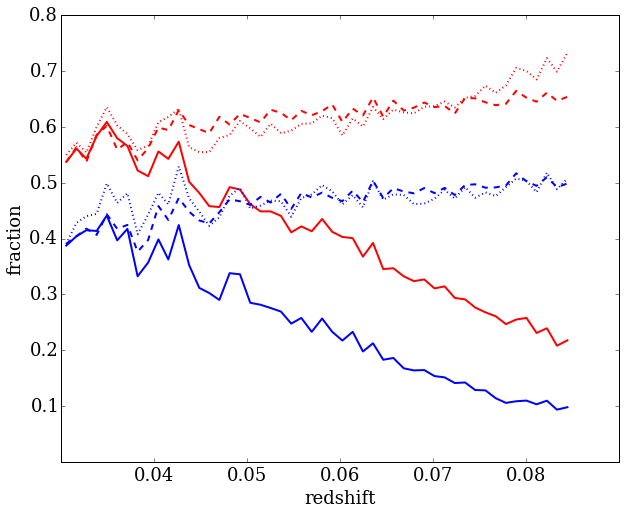

In [40]:
from scipy.stats import binned_statistic

colours = 'rbgmy'
x,edges,assignments = binned_statistic(data[volume_ok]['REDSHIFT_1'],data[volume_ok]['REDSHIFT_1'],bins=50)

def get_fraction(data,assignments,threshold):
    
    fracs = np.zeros(len(np.unique(assignments)))
    
    for i,b in enumerate(np.unique(assignments)):
        data_b = data[assignments == b]
        f_greater = data_b > p_th
        frac = np.sum(f_greater)/len(f_greater)
        fracs[i] = frac
    
    return fracs
        

for j,p_th in enumerate(np.linspace(0.5,0.8,2)):
    
    raw_fracs = get_fraction(raw,assignments,p_th)
    bin_fracs = get_fraction(bin_method,assignments,p_th)
    fit_fracs = get_fraction(fit_method,assignments,p_th)
    
    plt.plot(x,raw_fracs,linestyle='solid',color=colours[j],linewidth=2)
    plt.plot(x,bin_fracs,linestyle='dashed',color=colours[j],linewidth=2)
    plt.plot(x,fit_fracs,linestyle='dotted',color=colours[j],linewidth=2)
    
plt.xlabel('redshift')
plt.ylabel('fraction')

# Red: p > 0.5
# Blue: p > 0.8
# Solid: raw
# Dashed: Binning method
# Dotted: Function fitting method

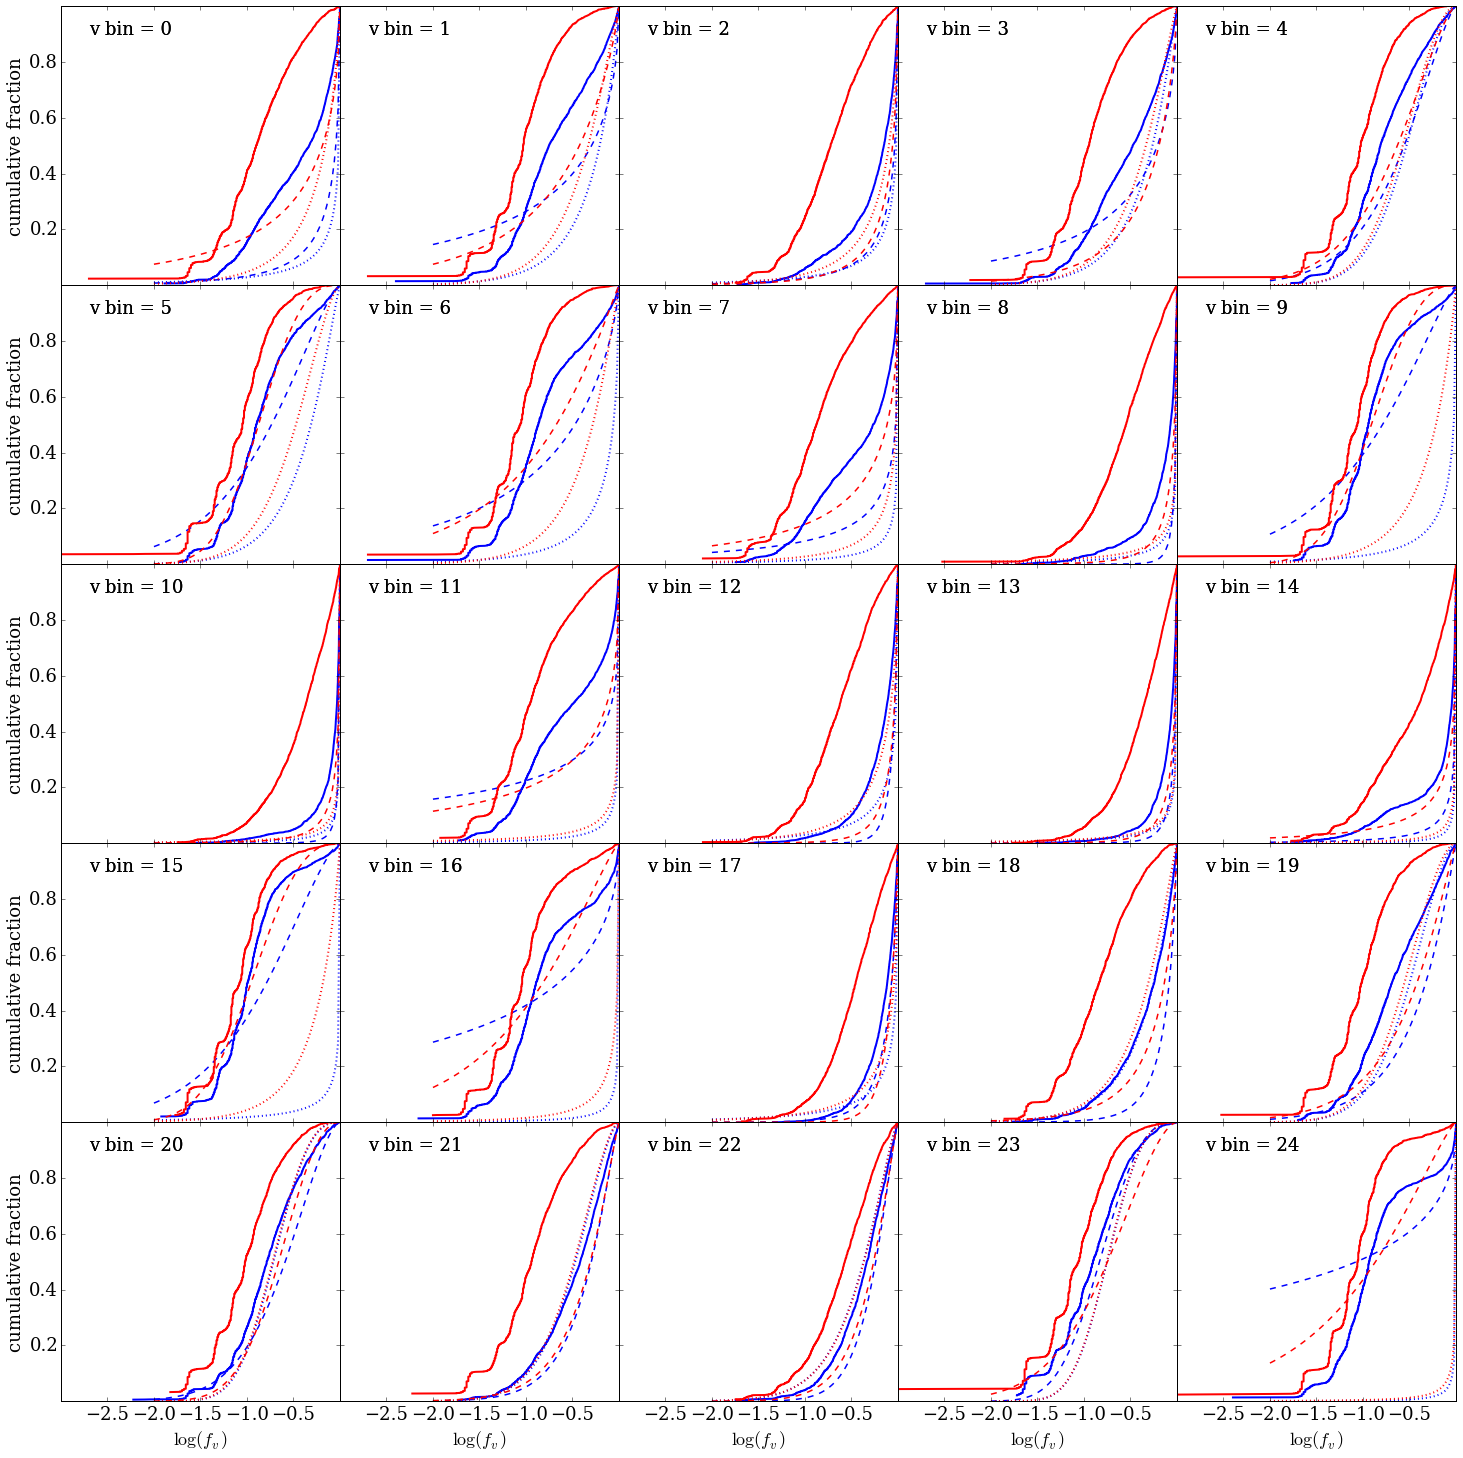

In [44]:
# Check how well the fitting worked?

f = fit_setup['func']

n = len(np.unique(vbins))
colors = 'br'

fig,axarr = make_axes(n_morph=n)

xg = np.linspace(-2,0,100)

for m,v in enumerate(np.unique(vbins)):
    
    z_bins_v = zbins_coarse[(vbins == v)] # HERE IS WHERE WE GO WRONG/ NEED TO CHANGE DEPENDING ON BINS!!!
    high_z = np.max(z_bins_v)
    low_z_data = data[(vbins == v) & (zbins_coarse == 1)]
    high_z_data = data[(vbins == v) & (zbins_coarse == high_z)]
    
    low_z_params = fit_vbin_results[(fit_vbin_results['vbin'] == v) 
                                    & (fit_vbin_results['zbin'] == 1)]
    high_z_params = fit_vbin_results[(fit_vbin_results['vbin'] == v) 
                                     & (fit_vbin_results['zbin'] == high_z)]  
    param_list = [low_z_params,high_z_params]
    
    for m2,z_data in enumerate([low_z_data,high_z_data]):
        
        params = param_list[m2]
        
        fv = z_data[question + '_' + answer + '_weighted_fraction']
        fv = np.sort(fv)
        cf = np.linspace(0,1,len(fv))
        
        select = fv != 0
        log10fv = np.log10(fv[select])
        cf_s = cf[select]
        
        axarr[m].plot(log10fv,cf_s,color=colors[m2],linewidth=2)
        axarr[m].plot(xg,f(xg,params['k'],params['c']),
                      linestyle='dashed',color=colors[m2],linewidth=1.5)
        
        x = [params['Mr'],params['R50'],params['redshift']]
        k = k_func(x, *kparams[0])
        c = c_func(x, *cparams[0])
        k[k < kmin] = kmin
        k[k > kmax] = kmax
        c[c < cmin] = cmin
        c[c > cmax] = cmax
        if len(params) != 0:
            axarr[m].plot(xg,f(xg,k,c),linestyle='dotted',color=colors[m2],linewidth=2)
            axarr[m].text(0.1,0.9,'v bin = {}'.format(v),transform=axarr[m].transAxes)
        
# Highest redshift bin = red
# Lowest redshift bin = blue

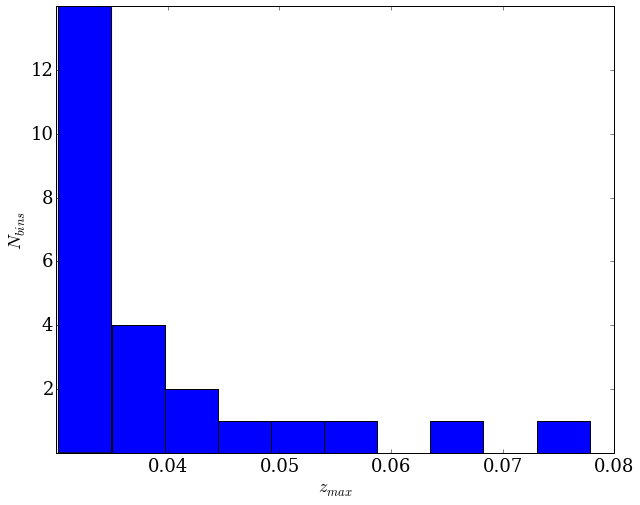

In [42]:
# Plot the limits of the low-redshift bins

z_maxs = []

for v in np.unique(vbins):

    zbins_0 = (vbins == v) & (zbins == 1)
    redshift_0_bin = data['REDSHIFT_1'][zbins_0]
    z_max = np.max(redshift_0_bin)
    #print('v={}'.format(v) + ',z_max={0:.3f}'.format(z_max))
    z_maxs.append(z_max)
    
plt.hist(z_maxs)
plt.xlabel('$z_{max}$')
plt.ylabel('$N_{bins}$')